### Pokedex


## Pokemon datasets

In [1]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
from keras.preprocessing import image

In [123]:
p = Path('./dataset/')
dirs = p.glob('*')
image_data = []
labels = []
label_dict = {}
label_pok = {}
cnt = 0
xx = []
for folder_dir in dirs:
    label = str(folder_dir).split('/')[-1]
    label_dict[label] = cnt
    label_pok[cnt] = label
    xx.append(label)
    cnt += 1
    if cnt == 4:
        break

In [68]:
(label_dict)

{'Zapdos': 0, 'Kadabra': 1, 'Omanyte': 2, 'Shellder': 3}

In [69]:
dirs = p.glob('*')

In [70]:
image_paths = []
cc = 0
for folder_dir in dirs:
    label = str(folder_dir).split('/')[-1]
    # print(label)
    cnt = 0

    for img_path in folder_dir.glob('*.jpg'):
        # print(img_path)
        img  = image.load_img(img_path,target_size=(32,32))
        img_array = image.img_to_array(img)

        image_data.append(img_array)
        labels.append(label_dict[label])
        cnt += 1
    cc += 1
    if cc == 4:
        break

In [71]:
len(labels)

255

In [72]:
len(image_data)

255

In [74]:
# label_dict['Abra']

### visualization

In [75]:
import numpy as np

In [76]:
X = np.array(image_data)/255
Y = np.array(labels)

In [77]:
X.shape

(255, 32, 32, 3)

In [78]:
X = X.reshape(X.shape[0],-1)

In [79]:
X.shape

(255, 3072)

In [80]:
Y = Y.reshape((-1,1))

In [81]:
Y.shape

(255, 1)

In [82]:
data = np.hstack((X,Y))
np.random.shuffle(data)
X, Y = data[:,:-1],data[:,-1]

In [83]:
X.shape

(255, 3072)

In [84]:
Y.shape

(255,)

In [85]:
plt.style.use('seaborn')
def drawImg(img,label):
    plt.imshow(img)
    plt.axis('off')
    plt.show()

TypeError: Invalid shape (3072,) for image data

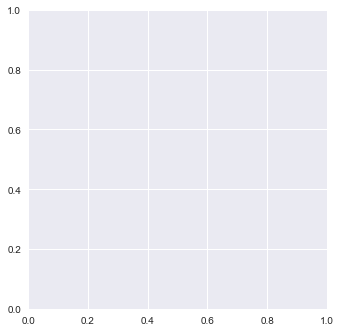

In [86]:
drawImg(X[0],labels[0])

### Building a pokemon classifier


In [87]:
split = int(X.shape[0]*0.8)

X_ = np.array(X)
Y_ = np.array(Y)

# Training Set
X_train = X_[:split,:]
Y_train = Y_[:split]

# Test Set
X_test = X_[split:,:]
Y_test = Y_[split:]

In [88]:
X_train.shape,Y_train.shape

((204, 3072), (204,))

In [89]:
X_test.shape,Y_test.shape

((51, 3072), (51,))

In [90]:
len(label_dict)

4

In [91]:
def softmax(a):
    e_pa = np.exp(a)
    return e_pa/np.sum(e_pa,axis=1,keepdims=True)

In [92]:
class NeuralNetwork:
    def __init__(self,input_size,layers,output_size):
        models = {}
        models['W1'] = np.random.randn(input_size,layers[0])
        models['b1'] = np.zeros((1,layers[0]))

        models['W2'] = np.random.randn(layers[0],layers[1])
        models['b2'] = np.zeros((1,layers[1]))

        models['W3'] = np.random.randn(layers[1],output_size)
        models['b3'] = np.zeros((1,output_size))

        self.model = models

    def forward(self,x):

        W1,W2,W3 = self.model['W1'],self.model['W2'],self.model['W3']
        b1,b2,b3 = self.model['b1'],self.model['b2'],self.model['b3']

        z1 = np.dot(x,W1) + b1
        a1 = np.tanh(z1)

        z2 = np.dot(a1,W2) + b2
        a2 = np.tanh(z2)

        z3 = np.dot(a2,W3) + b3
        y_ = softmax(z3)

        #Store the outputs of each layer for back-propagation
        self.activation_outputs = (a1,a2,y_)

        return y_

    def backward(self,x,y,learning_rate=0.001):

        W1,W2,W3 = self.model['W1'],self.model['W2'],self.model['W3']
        a1,a2,y_ = self.activation_outputs

        delta3 = y_ - y

        dw3 = np.dot(a2.T,delta3) #)h2+1,C) => (h2+1,m) X (m,C)
        db3 = np.sum(delta3,axis=0)

        delta2 = (1-np.square(a2))*np.dot(delta3,W3.T)  #(m,h2+1) => (m,h2+1) *(m,C X C,h2+1)
        dw2 = np.dot(a1.T,delta2)
        db2 = np.sum(delta2,axis=0)

        delta1 = (1-np.square(a1))*np.dot(delta2,W2.T)
        dw1 = np.dot(x.T,delta1)
        db1 = np.sum(delta1,axis=0)

        self.model['W1'] -= learning_rate*dw1
        self.model['W2'] -= learning_rate*dw2
        self.model['W3'] -= learning_rate*dw3

        self.model['b1'] -= learning_rate*db1
        self.model['b2'] -= learning_rate*db2
        self.model['b3'] -= learning_rate*db3



    def predict(self,x):
        y_out = self.forward(x)
        return np.argmax(y_out,axis=1)

    def summary(self):
        W1,W2,W3 = self.model['W1'],self.model['W2'],self.model['W3']
        a1,a2,y_ = self.activation_outputs

        print("W1 ",W1.shape)
        print("A1 ",a1.shape)

        print("W2 ",W2.shape)
        print("A2 ",a2.shape)

        print("W3 ",W3.shape)
        print("Y_ ",y_.shape)



In [93]:
def loss(y_oht,p):
    l = -np.mean(y_oht*np.log(p))
    return l

In [94]:
# One hot notation
# depth is nothing but unique labels

def one_hot(y,depth):
    m = y.shape[0]
    y_oht = np.zeros((m, depth))
    y_oht[np.arange(m), y] = 1
    return y_oht

In [95]:
def train(X,Y,model,epochs,logs=True):
    """Creates and Model and Trains it!"""

    training_loss = []
    classes = len(np.unique(Y))
    Y_OHT = one_hot(Y,classes)

    for ix in range(epochs):
        Y_ = model.forward(X)
        l = loss(Y_OHT,Y_)
        training_loss.append(l)
        model.backward(X,Y_OHT)
        if(logs and ix%50==0):
            print("Epoch %d Loss %.4f"%(ix,l),end='\n')

    #model.summary()
    return training_loss

In [96]:
model = NeuralNetwork(input_size=X_train.shape[1],layers=[100,50],output_size=len(label_dict))

In [99]:
losses = train(X=X_train,Y=Y_train,model=model,epochs=500)

Epoch 0 Loss 2.2310
Epoch 50 Loss 0.1403
Epoch 100 Loss 0.0790
Epoch 150 Loss 0.0950
Epoch 200 Loss 0.0631
Epoch 250 Loss 0.0506
Epoch 300 Loss 0.0448
Epoch 350 Loss 0.0411
Epoch 400 Loss 0.0435
Epoch 450 Loss 0.0339


In [109]:
def getaccuracy(X,Y,model):
    outputs = model.predict(X)
    acc = np.sum(outputs == Y)/Y.shape[0]*100
    return acc,outputs

In [101]:
acc, outputs = getaccuracy(X_train,Y_train,model)

In [102]:
print("training accuracy -->",acc)

training accuracy --> 0.9656862745098039


In [103]:
len(np.unique(Y_train))

4

In [98]:
Y_train = np.array(Y_train,dtype='uint8')

In [104]:
Y_train

array([3, 3, 2, 3, 3, 1, 1, 2, 3, 2, 1, 3, 2, 1, 3, 0, 3, 1, 0, 2, 1, 3,
       3, 2, 0, 3, 3, 3, 3, 2, 1, 0, 1, 3, 0, 1, 2, 3, 3, 3, 3, 3, 3, 2,
       2, 3, 1, 3, 0, 2, 1, 0, 3, 1, 2, 0, 0, 2, 3, 2, 1, 1, 3, 3, 0, 2,
       3, 2, 0, 0, 0, 3, 1, 0, 0, 2, 2, 2, 2, 0, 3, 2, 1, 0, 0, 3, 2, 3,
       3, 3, 0, 0, 0, 2, 1, 2, 2, 3, 1, 0, 0, 3, 3, 0, 2, 3, 3, 1, 3, 3,
       0, 2, 3, 1, 2, 1, 1, 2, 3, 2, 2, 1, 2, 2, 0, 1, 3, 2, 1, 0, 3, 0,
       3, 3, 0, 3, 0, 0, 1, 2, 0, 0, 1, 3, 1, 0, 3, 2, 0, 1, 2, 3, 2, 1,
       3, 3, 1, 1, 1, 1, 0, 2, 3, 0, 0, 1, 0, 0, 1, 0, 3, 1, 2, 3, 2, 1,
       2, 2, 1, 1, 3, 0, 3, 2, 3, 1, 0, 0, 3, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       2, 3, 1, 3, 3, 0], dtype=uint8)

In [105]:
X_train.shape

(204, 3072)

In [106]:
X_.shape

(255, 3072)

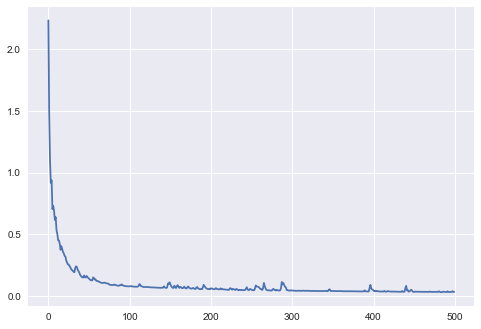

In [107]:
plt.plot(losses)
plt.show()

In [110]:
getaccuracy(X_test,Y_test,model)

(33.33333333333333,
 array([3, 2, 0, 0, 3, 3, 3, 0, 1, 1, 0, 3, 0, 1, 3, 0, 0, 2, 1, 1, 0, 3,
        3, 3, 3, 3, 1, 1, 3, 3, 0, 1, 0, 1, 2, 3, 1, 1, 0, 3, 1, 1, 0, 0,
        0, 3, 1, 2, 1, 0, 3]))

In [111]:
from sklearn.metrics import classification_report

In [112]:
print(classification_report(outputs,Y_train))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        46
           1       0.94      1.00      0.97        46
           2       1.00      0.90      0.95        50
           3       0.95      0.97      0.96        62

    accuracy                           0.97       204
   macro avg       0.97      0.97      0.97       204
weighted avg       0.97      0.97      0.97       204



In [113]:
from sklearn.metrics import confusion_matrix

In [114]:
from visualize import plot_confusion_matrix

In [118]:
outputs = model.predict(X_train)

In [120]:
cnf_matrix = confusion_matrix(outputs,Y_train)

Confusion matrix, without normalization
[[46  0  0  0]
 [ 0 46  0  0]
 [ 1  1 45  3]
 [ 0  2  0 60]]


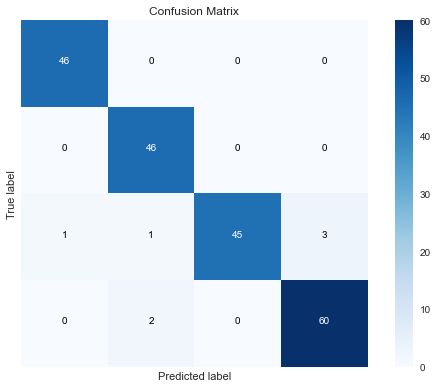

In [124]:
plot_confusion_matrix(cnf_matrix,classes=labels,title="Confusion Matrix")


## Confusion Matrix for X_test

In [125]:
outputs = model.predict(X_test)

In [126]:
cnf_matrix = confusion_matrix(outputs,Y_test)

Confusion matrix, without normalization
[[5 4 3 3]
 [4 4 3 4]
 [1 0 0 3]
 [2 3 4 8]]


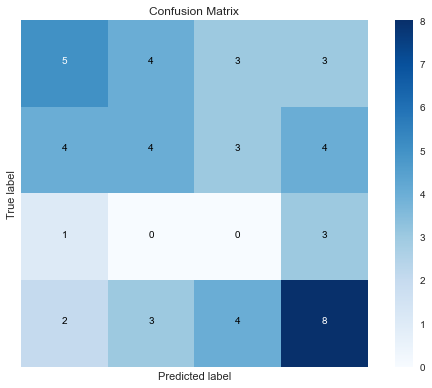

In [127]:
plot_confusion_matrix(cnf_matrix,classes=labels,title="Confusion Matrix")